In [1]:
import numpy as np
from numpy import radians, pi
from lib.cartpolesystem import CartPoleSystem
from lib.cartpoleenv import CartPoleEnv
from lib.colors import Colors
from lib.controllers import LQR
import time
from time import perf_counter
from matplotlib import pyplot as plt
from scipy.io import savemat

In [2]:
dt = 0.01
g = 9.81

system = CartPoleSystem(
    (0.0, 0.5, 0.005, -0.8, 0.8, Colors.red),
    (0.2, 8.7e-5, 8.7e-5, 0.02, 0.05, 24.0, Colors.black),
    [
        (0, 1, 0.2, 0.001, Colors.green),
        (0, 0.5, 0.2, 0.001, Colors.green),
    ],
    g,
    dt,
    "rk4",
    "nonlinear",
    None
)

n = system.num_poles
system.system_noise_covariance = 0.0000000000001 * np.diag(np.ones(2+2*n))

env = CartPoleEnv(system, dt, g)
env.observation_space.shape

(6, 1)

In [3]:
linearization_x0 = np.zeros((2+2*n, 1))
linearization_u0 = np.vstack([0])

# A, B = system.linearize_old()
A, B = system.linearize(linearization_x0, linearization_u0)

savemat("AB.mat", {"A": A, "B": B})

C = np.eye(2+2*n)
D = np.zeros((2+2*n, 1))

ct_dt = dt

sys = LQR(A, B, C, D, dt=ct_dt)

Q = np.eye(2+2*n)
R = np.diag([0.1])

sys.calculate_K_lqr(Q, R)
sys.calculate_K_r()

c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\controllers.py:31: RuntimeWarning: divide by zero encountered in divide
  K_r = np.true_divide(1, self.D + self.C @ np.linalg.inv(-self.A + self.B @ self.K) @ self.B)
c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\controllers.py:36: RuntimeWarning: divide by zero encountered in divide
  K_r_d = np.true_divide(1, self.D + self.C @ np.linalg.inv(np.eye(self.A_d.shape[0]) - self.A_d + self.B_d @ self.K_d) @ self.B_d)


In [4]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("A")
print(sys.A)
print("B")
print(sys.B)

A
[[ 0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000 -0.603 -3.020  0.003 -1.510  0.003]
 [ 0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  2.586  54.988 -0.056  6.472 -0.013]
 [ 0.000  0.000  0.000  0.000  0.000  1.000]
 [ 0.000  2.586  12.945 -0.013  48.515 -0.099]]
B
[[ 0.000]
 [ 1.437]
 [ 0.000]
 [-6.158]
 [ 0.000]
 [-6.158]]


In [6]:
x0 = np.vstack([-0.4, 0] + [radians(1), 0]*n)

obs, _ = env.reset(x0)

r = np.array(
    [0.1, 0] + [0, 0]*n
)

end_time = 10
N = int(end_time/dt)

states = {
    "u": [],
    "i": [],
}

last_update = perf_counter()

for i in range(N):
    
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()
    
    u = sys.feedback_d(obs.T[0], r)
    u = np.vstack([u])
    max_Ia = 100
    max_Va_from_Ia = system.Ra * max_Ia + system.K*obs[1]/system.r
    min_Va_from_Ia = -max_Va_from_Ia

    if u[0] > min(system.max_Va, max_Va_from_Ia):
        u[0] = min(system.max_Va, max_Va_from_Ia)
    elif u[0] < max(-system.max_Va, min_Va_from_Ia):
        u[0] = max(-system.max_Va, min_Va_from_Ia)

    states["u"].append(u[0][0])
    states["i"].append((u[0][0] - system.K*obs[1]/system.r)/system.Ra)

    time1 = time.perf_counter()
    obs, reward, done, msg, _ = env.step(u)
    time2 = time.perf_counter()
    env.render()
env.close()

print(time2-time1)

0.00041779992170631886


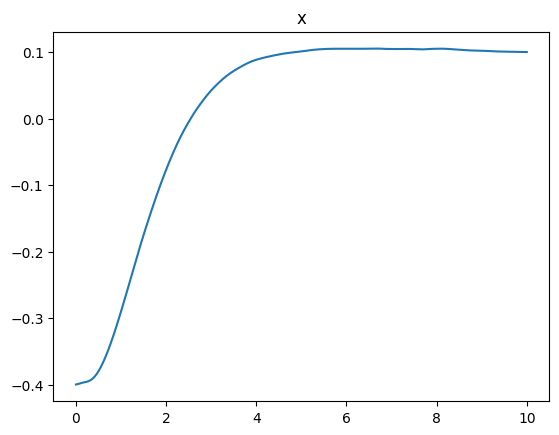

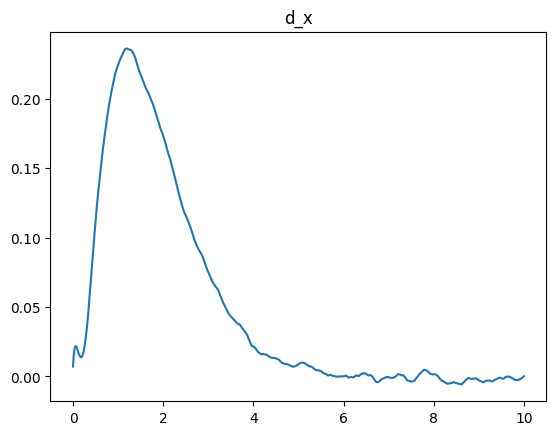

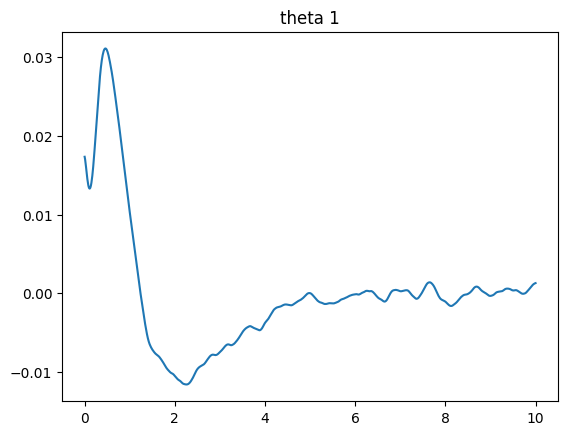

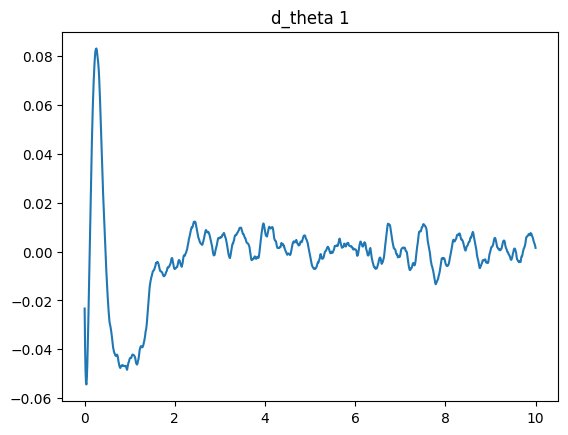

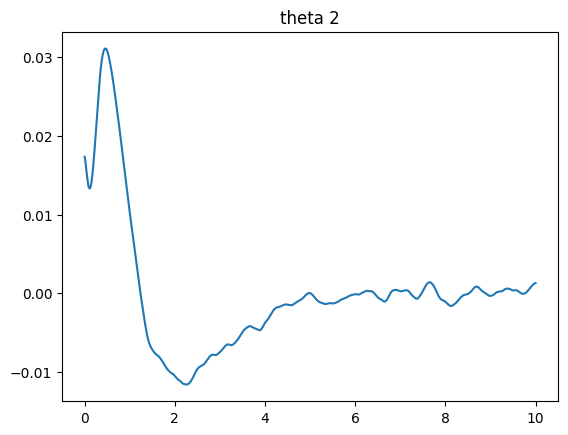

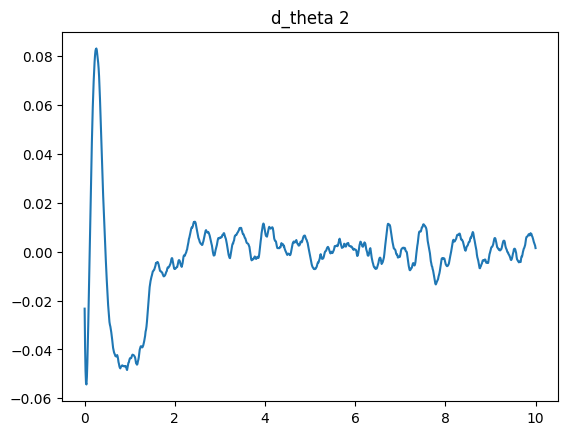

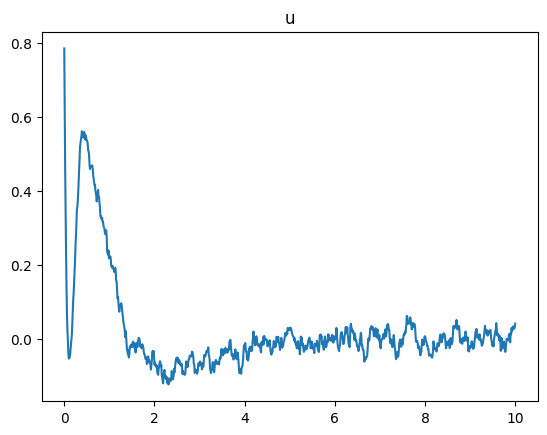

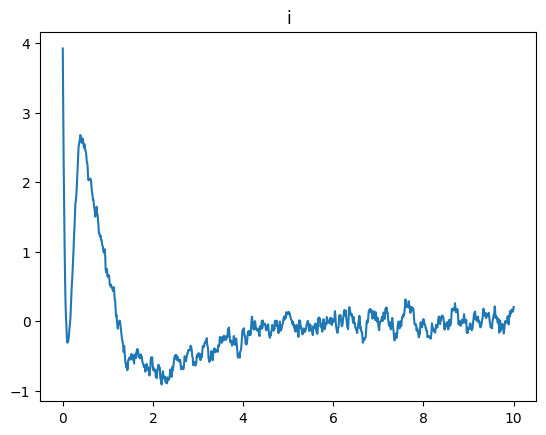

In [31]:
t = np.linspace(0, end_time, N)
x = env.system.state[0][1:]

plt.plot(t, x)
plt.title("x")
plt.show()

d_x = env.system.state[1][1:]

plt.plot(t, d_x)
plt.title("d_x")
plt.show()

for k in range(system.num_poles):
    theta = env.system.state[2+k*2][1:]

    plt.plot(t, theta)
    plt.title(f"theta {k+1}")
    plt.show()

    d_theta = env.system.state[2+k*2+1][1:]

    plt.plot(t, d_theta)
    plt.title(f"d_theta {k+1}")
    plt.show()

plt.plot(t, states["u"])
plt.title("u")
plt.show()

plt.plot(t, states["i"])
plt.title("i")
plt.show()